In [7]:
import sys; sys.path.insert(0, '..')
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from df_utils import df_wrapper, get_timestamp_and_pose, POSE_MAP, combine_dataframes
from dataclasses import dataclass

### Filnavn og antall sensorer

Her defineres filnavnene som skal med for trenings- og testsett.
Antall sensorer blir også definert her

In [8]:
@dataclass
class training_class:
    csv_file: str
    annot_file: str

@dataclass
class testing_class:
    csv_file: str
    annot_file: str

training_files = {
    "Martin": training_class("../../data/train_data/martin_train_3_030221.csv", 
                            "../../data/annotation/training/martin_train_3_030221.txt"),
    "Simon": training_class("../../data/train_data/simon_train_3_080221.csv",
                            "../../data/annotation/training/simon_train_3_080221.txt"),
    "Jonas": training_class("../../data/train_data/jonas_train_3_080221.csv",
                            "../../data/annotation/training/jonas_train_3_080221.txt"),
    "Elise": training_class("../../data/train_data/elise_train_3_090221.csv",
                            "../../data/annotation/training/elise_train_3_090221.txt")
}

testing_file = testing_class("../../data/test_data/martin_test_3_040221.csv",
                             "../../data/annotation/testing/martin_test_3_040221.txt")

AMOUNT_OF_SENSORS = 3

### Databehandling

Basert på filnavnene over lages det dataframes med riktig antall sensorer ifht. definisjonen i AMOUNT_OF_SENSORS

In [9]:
knn_train = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    stamped_poses = get_timestamp_and_pose(training_files[key].annot_file, POSE_MAP)
    elem.align_poses(stamped_poses)
    knn_train.append(elem)

y_train = pd.concat([x.df['Pose'] for x in knn_train])

knn_test = df_wrapper(testing_file.csv_file)
knn_test.concat_sensor_data(AMOUNT_OF_SENSORS)
test_stamped_poses = get_timestamp_and_pose(testing_file.annot_file, POSE_MAP)
knn_test.align_poses(test_stamped_poses)
y_test = knn_test.df["Pose"]
y_test.index = [i for i in range(len(y_test))]

### Visualisering

Her visualiserer vi dataframesene, med alle treningssettene før vi har testsettet lengst til høyre

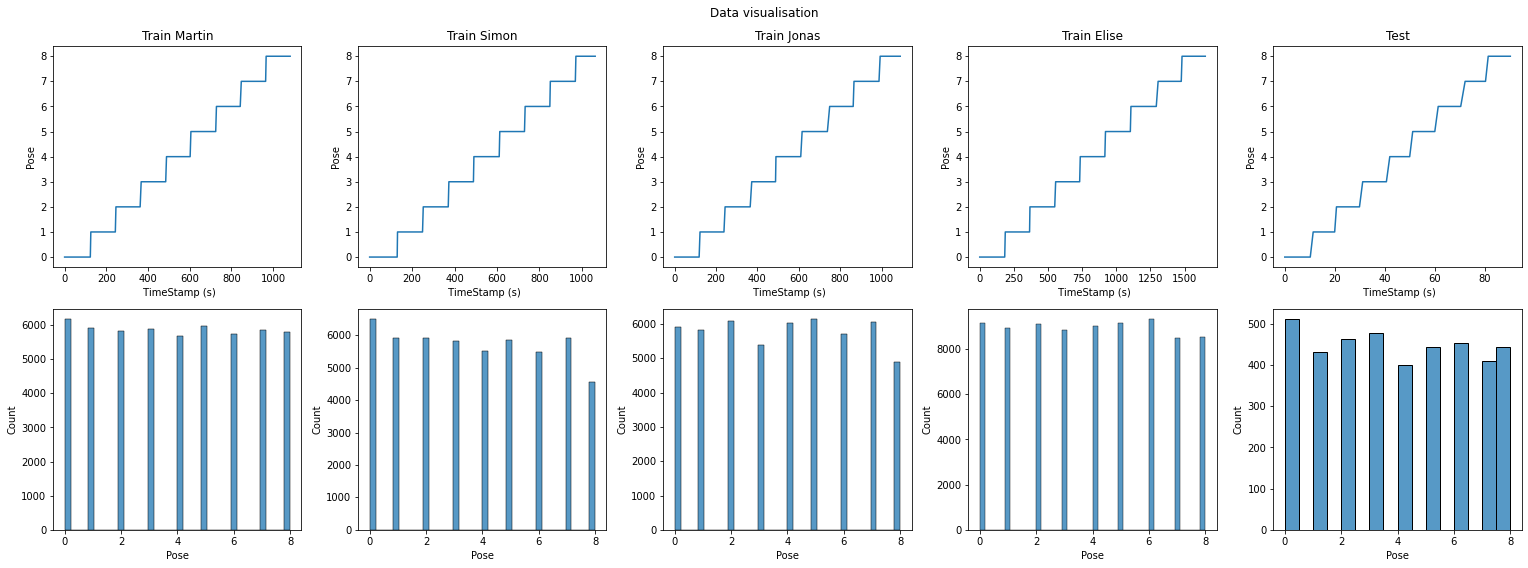

In [10]:
cols = []
height=8
width=(height/1.5)*len(knn_train)
fig, axes = plt.subplots(2, len(knn_train)+1, figsize=(width, height))
fig.suptitle('Data visualisation')
for i in range(len(knn_train)):
    sns.lineplot(ax=axes[0, i], data=knn_train[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=knn_train[i].df["Pose"])
    cols.append('Train')    
for i, key in enumerate(training_files):
    cols[i] += f' {key}'
sns.lineplot(ax=axes[0, len(knn_train)], data=knn_test.df, x=" TimeStamp (s)", y='Pose')
sns.histplot(ax=axes[1, len(knn_train)], data=y_test)
cols.append('Test')
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

### Sammenslåing av dataframes

Her kombineres treningssettene

In [11]:
x_train = combine_dataframes([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in knn_train])
x_test = knn_test.df.drop([' TimeStamp (s)', 'Pose'], axis=1) 

x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(236946, 48)
(236946,)
(4039, 48)
(4039,)


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train_numpy)
x_train_numpy = scaler.transform(x_train_numpy)
x_test_numpy = scaler.transform(x_test_numpy)


### Keras Model

Leger en enkel modell

In [35]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)

LR = 0.0001
EPOCH = 50
BATCH_SIZE = 50
ACTIVATION1 = 'relu'
ACTIVATION2 = 'softmax'
OPTIM = Adam(learning_rate=LR)

def get_compiled_model(input_shape=(AMOUNT_OF_SENSORS*16), output_shape=len(POSE_MAP)):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(AMOUNT_OF_SENSORS, activation=ACTIVATION1),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(int((AMOUNT_OF_SENSORS + output_shape)/2), activation=ACTIVATION1),
        tf.keras.layers.Dropout(rate=0.75),
        tf.keras.layers.Dense(output_shape, activation=ACTIVATION2)
    ])
    model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
    return model

In [36]:
model = get_compiled_model()
model.fit(x=x_train_numpy, y=y_train, batch_size=BATCH_SIZE, validation_data=(x_test_numpy, y_test), shuffle=True, epochs=EPOCH)

Epoch 1/50
4739/4739 [==============================] - 3s 677us/step - loss: 2.1635 - accuracy: 0.1390 - val_loss: 2.0970 - val_accuracy: 0.2248
Epoch 2/50
4739/4739 [==============================] - 3s 723us/step - loss: 2.0536 - accuracy: 0.1776 - val_loss: 1.8933 - val_accuracy: 0.4150
Epoch 3/50
4739/4739 [==============================] - 3s 708us/step - loss: 1.9706 - accuracy: 0.1963 - val_loss: 1.7347 - val_accuracy: 0.3610
Epoch 4/50
4739/4739 [==============================] - 4s 772us/step - loss: 1.9218 - accuracy: 0.2182 - val_loss: 1.6304 - val_accuracy: 0.4553
Epoch 5/50
4739/4739 [==============================] - 4s 753us/step - loss: 1.8885 - accuracy: 0.2326 - val_loss: 1.5806 - val_accuracy: 0.5647
Epoch 6/50
4739/4739 [==============================] - 3s 738us/step - loss: 1.8694 - accuracy: 0.2364 - val_loss: 1.5593 - val_accuracy: 0.4627
Epoch 7/50
4739/4739 [==============================] - 3s 736us/step - loss: 1.8535 - accuracy: 0.2469 - val_loss: 1.5672 -

<AxesSubplot:>

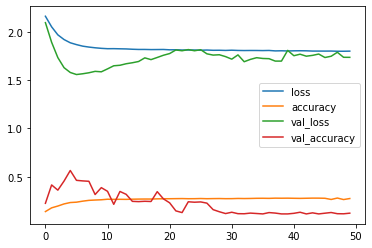

In [37]:
losses = pd.DataFrame(model.history.history)
losses.plot()

494
% of corrects: 12.230750185689528


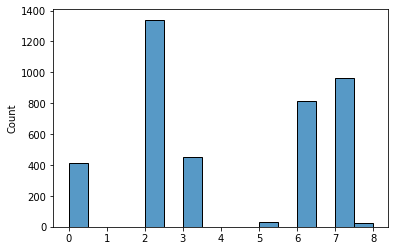

In [38]:
predictions = model.predict(x_test_numpy)
predictions_final = []  
y_test_arr = []
for index in range(len(predictions)):
    predictions_final.append(predictions[index].argmax())
    y_test_arr.append(y_test[index].argmax())
sns.histplot(predictions_final)

number_of_corrects = 0
for i in range(len(predictions_final)):
    if(predictions_final[i] == y_test_arr[i]):
        number_of_corrects += 1
print(number_of_corrects)
print("% of corrects: {}".format(number_of_corrects/len(predictions_final)*100))

<AxesSubplot:xlabel='x', ylabel='y'>

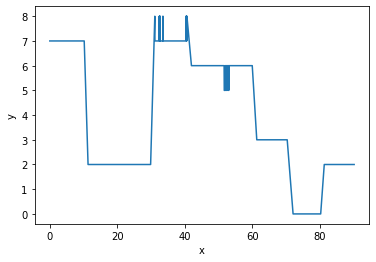

In [39]:
df_predict = pd.DataFrame({'x': knn_test.df[' TimeStamp (s)'],'y':predictions_final})
sns.lineplot(data=df_predict,x='x',y='y')